## Upsample a hex cube and create mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import Delaunay

#### Step 1: Define a unit hex as an example
(Note that local-to-global mapping is trivial in this case)

In [2]:
# Step 1: Define the unit hexahedron vertices
vertices_hex = np.array([
    [0, 0, 0],  # v1
    [1, 0, 0],  # v2
    [1, 1, 0],  # v3
    [0, 1, 0],  # v4
    [0, 0, 1],  # v5
    [1, 0, 1],  # v6
    [1, 1, 1],  # v7
    [0, 1, 1]   # v8
])

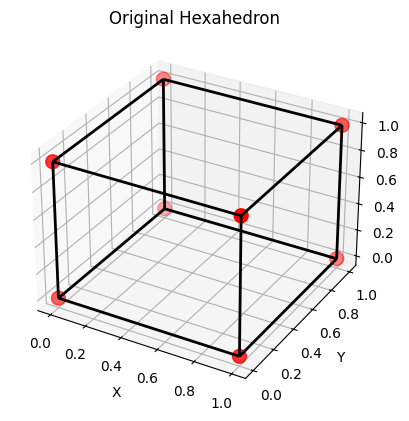

In [3]:
# Plotting function to visualize vertices and edges
def plot_vertices_edges(vertices, edges, title="Vertices and Edges"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='r', s=100)
    
    # Create a list of line segments from edge vertices to plot the edges
    edge_lines = [(vertices[start], vertices[end]) for start, end in edges]
    lc = Line3DCollection(edge_lines, colors='k', linewidths=2)
    ax.add_collection(lc)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(title)
    plt.show()

# Define edges for plotting
edges_hex = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face edges
    (4, 5), (5, 6), (6, 7), (7, 4),  # top face edges
    (0, 4), (1, 5), (2, 6), (3, 7),  # vertical edges
]

# Plot original vertices and edges
plot_vertices_edges(vertices_hex, edges_hex, "Original Hexahedron")

#### Step 2: Define quadratic spline bases for 3D

In [4]:
# Quadratic B-spline basis functions in 1D
def B0(u):
    return (1 - u)**2 / 2 if 0 <= u <= 1 else 0

def B1(u):
    return (-2*u**2 + 2*u + 1) / 2 if 0 <= u <= 1 else 0

def B2(u):
    return u**2 / 2 if 0 <= u <= 1 else 0

# 3D Quadratic B-spline basis functions using tensor product
def B_ijk(i, j, k, u, v, w):
    # Basis functions along each axis
    basis_u = [B0(u), B1(u), B2(u)]
    basis_v = [B0(v), B1(v), B2(v)]
    basis_w = [B0(w), B1(w), B2(w)]
    
    # Tensor product of basis functions
    return basis_u[i] * basis_v[j] * basis_w[k]

# Evaluate basis functions at a specific point in the parametric space (u, v, w)
def evaluate_spline_basis(u, v, w):
    values = np.zeros((3, 3, 3))  # Initialize a 3x3x3 grid for basis function values
    for i in range(3):
        for j in range(3):
            for k in range(3):
                values[i, j, k] = B_ijk(i, j, k, u, v, w)
    return values

#### Step 3: Upsampling and Triangulation Data Preparation

In [7]:
# Step 3: Upsample and Triangulate Hexahedral Faces
def upsample_and_triangulate_hex(vertices_hex):
    vertices_hex = np.array(vertices_hex, dtype=np.float64)

    faces_indices = [
        (0, 1, 2, 3),
        (4, 5, 6, 7),
        (0, 1, 5, 4),
        (1, 2, 6, 5),
        (2, 3, 7, 6),
        (3, 0, 4, 7),
    ]

    upsampled_points = []
    triangulated_faces = []
    point_index_offset = 0

    for face in faces_indices:
        face_vertices = vertices_hex[np.array(face)]
        mid_points = [(face_vertices[i] + face_vertices[(i+1) % 4]) / 2 for i in range(4)]
        all_points = np.vstack([face_vertices, mid_points])
        center_point = np.mean(face_vertices, axis=0)
        all_points = np.vstack([all_points, center_point])

        upsampled_points.extend(all_points)

        # Projecting onto the plane with the greatest spread of points
        projections = [all_points[:, [1, 2]], all_points[:, [0, 2]], all_points[:, [0, 1]]]
        areas = [np.ptp(proj[:, 0]) * np.ptp(proj[:, 1]) for proj in projections]
        points2d = projections[np.argmax(areas)]

        # Safe check if the projected area is zero, which indicates colinear points in 2D
        if np.ptp(points2d[:, 0]) == 0 or np.ptp(points2d[:, 1]) == 0:
            continue

        try:
            delaunay_tri = Delaunay(points2d)
            for simplex in delaunay_tri.simplices:
                triangulated_faces.append([point_index_offset + i for i in simplex])
        except Exception as e:
            print("Failed to triangulate face:", e)
            continue

        point_index_offset += len(all_points)

    return np.array(upsampled_points), np.array(triangulated_faces)

# Assuming vertices_hex is defined as your hexahedral vertices
upsampled_points, triangulated_faces = upsample_and_triangulate_hex(vertices_hex)

# Now, you can use upsampled_points and triangulated_faces for further processing or visualization

#### Step 4: Local-global mapping

In [9]:
# Define the reference and real hexahedrons (identical in this case)
reference_hex = vertices_hex  # This is the same as vertices_hex defined earlier
real_hex = reference_hex.copy()  # Make a copy for clarity, though they're identical in this case


TODO: Add mapping for general hex cubes

### Step 5: Construct W: Mapping between S and M

In [10]:
# Evaluate the basis functions at each of the upsampled points
spline_values_at_points = [evaluate_spline_basis(point[0], point[1], point[2]) for point in upsampled_points]

# Initialize matrix W with zeros; this will be a 3D matrix where the third dimension corresponds to x, y, and z coordinates
W = np.zeros((len(upsampled_points), len(reference_hex), 3))

# Fill in matrix W with the evaluated spline values
for i, spline_values in enumerate(spline_values_at_points):
    for j, ref_point in enumerate(reference_hex):
        # Since there's no deformation, the weight is simply the spline value at the point
        W[i, j, :] = spline_values[j // 3, (j // 3) % 3, j % 3]

In [18]:
print(len(spline_values_at_points))
print(spline_values_at_points[0].shape)

54
(3, 3, 3)


In [14]:
print(W[:, :, 0])

[[0.125     0.125     0.        0.125     0.125     0.        0.
  0.       ]
 [0.        0.        0.        0.125     0.125     0.        0.
  0.       ]
 [0.        0.        0.        0.125     0.125     0.        0.125
  0.125    ]
 [0.        0.        0.        0.125     0.125     0.        0.
  0.       ]
 [0.03125   0.03125   0.        0.1875    0.1875    0.        0.
  0.       ]
 [0.        0.        0.        0.1875    0.1875    0.        0.03125
  0.03125  ]
 [0.        0.        0.        0.1875    0.1875    0.        0.03125
  0.03125  ]
 [0.03125   0.03125   0.        0.1875    0.1875    0.        0.
  0.       ]
 [0.0078125 0.0078125 0.        0.28125   0.28125   0.        0.0078125
  0.0078125]
 [0.        0.125     0.125     0.        0.125     0.125     0.
  0.       ]
 [0.        0.        0.        0.        0.125     0.125     0.
  0.       ]
 [0.        0.        0.        0.        0.125     0.125     0.
  0.125    ]
 [0.        0.        0.        0.        0.